In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler
import pandas as pd
import numpy as np
import random
import sc_toolbox
import scipy

from scipy.sparse import csr_matrix, isspmatrix
from anndata2ri import converter
from datetime import datetime

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import visualise as vs
from src.utils import utils as us
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
time_start = datetime.now()
%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
source(here::here('src/modules/DEG.R'))

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


# Load Data

In [6]:
adata = sc.read(config.PATHS.LOGS/'Reduced.h5ad')

print(adata.shape)
print('isspmatrix:', isspmatrix(adata.X))


print('Loaded Filtered AnnData object: number of cells', adata.n_obs)
print('Loaded Filtered AnnData object: number of genes', adata.n_vars) 
print('Available metadata for each cell: ', adata.obs.columns)

(39346, 7000)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 39346
Loaded Filtered AnnData object: number of genes 7000
Available metadata for each cell:  Index(['timepoint', 'line', 'tSNE_1', 'tSNE_2', 'cluster', 'timepoint_mapped',
       'batch', 'dataset', 'isHuman', 'isESC', 'n_genes_by_counts',
       'total_counts', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets', 'n_genes',
       'n_counts', 'cluster_ematb'],
      dtype='object')


In [7]:
adata.obs['time'] = adata.obs.timepoint_mapped.apply(
    lambda x: 'd{}'.format(x)).copy()
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: x.lower() in config.HUMANS).copy()

In [8]:
adata.obs['sample'] = adata.obs.line.astype(str) \
    + '_' + adata.obs.batch.astype(str) \
    + '_' + adata.obs.timepoint_mapped.astype(str)
obs_to_keep = ["sample", "cluster", "batch", "line", "time", "isHuman"]

In [9]:
if config.PROTO.SUBSET.USE_HIGHLY_VARIABLE:
    adata = adata[:, adata.var.highly_variable]
adata.X = adata.layers["counts"].copy()

# Exclude

In [10]:
idxs = np.prod([
    adata.obs.timepoint_mapped.apply(
        lambda x: x in config.PROTO.SUBSET.TIMEPOINTS),
], axis=0, dtype=np.bool_)
selected = adata[idxs, :].copy()
selected.obs.head()

,timepoint,line,tSNE_1,tSNE_2,cluster,timepoint_mapped,batch,dataset,isHuman,isESC,...,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo,QC_doublets,n_genes,n_counts,cluster_ematb,time,sample
AAACCTGAGTCCGTAT-4.d5_409b2_171212,d5,409b2,48.413219,-12.483613,C5,5,171212_b0,EMATB,True,False,...,84,1.931034,788,18.114943,0.030839,1870,4350,C5,d5,409b2_171212_b0_5
AAACCTGGTATCTGCA-4.d5_409b2_171212,d5,409b2,86.033093,-7.297135,C5,5,171212_b0,EMATB,True,False,...,39,1.308725,550,18.456376,0.056641,1374,2980,C5,d5,409b2_171212_b0_5
AAACCTGTCGTTGCCT-4.d5_409b2_171212,d5,409b2,34.884410,62.724772,C7,5,171212_b0,EMATB,True,False,...,182,2.132646,2403,28.157956,0.025751,2537,8534,C7,d5,409b2_171212_b0_5
AAACGGGCAATCGAAA-4.d5_409b2_171212,d5,409b2,28.472086,56.683741,C7,5,171212_b0,EMATB,True,False,...,354,2.537089,4262,30.545402,0.054755,3559,13953,C7,d5,409b2_171212_b0_5
AAACGGGCAATGGACG-4.d5_409b2_171212,d5,409b2,53.433417,-18.701272,C5,5,171212_b0,EMATB,True,False,...,47,1.776938,551,20.831758,0.032808,1332,2645,C5,d5,409b2_171212_b0_5


In [11]:
selected = selected[
    selected.obs.cluster.apply(
        lambda x: x in 
        config.PROTO.SUBSET.EMATB_CLUSTERS)].copy()
selected

AnnData object with n_obs × n_vars = 33889 × 7000
    obs: 'timepoint', 'line', 'tSNE_1', 'tSNE_2', 'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets', 'n_genes', 'n_counts', 'cluster_ematb', 'time', 'sample'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'batch_colors', 'cluster_colors', 'cluster_ematb_colors', 'harmony', 'line_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_triku', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'lognormcounts'
    obsp: 'connectivities', 'distances', 'harmony_connectivities', 'harmony_distances'

In [12]:
mapc = { 'C2': 0, 'C3': 1, 'C4': 2, 'C5': 2, 'C6': 2, 'C7': 2 }
selected.obs['cluster_group'] = selected.obs.cluster.apply(
    lambda x: 'G{}'.format(mapc[x]))

In [13]:
if config.PROTO.PSEUDO_BULK.TYPE == 'decoupler':
    adata_pb = decoupler.get_pseudobulk(
        selected, 'sample', 'cluster', selected.obs,
        min_cells=config.PROTO.GLM.MIN_CELLS,
        mode=config.PROTO.GLM.PSEUDOBULK_MODE)
assert config.PROTO.PSEUDO_BULK.TYPE == 'decoupler', 'NOT SUPPORTED ATM'

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


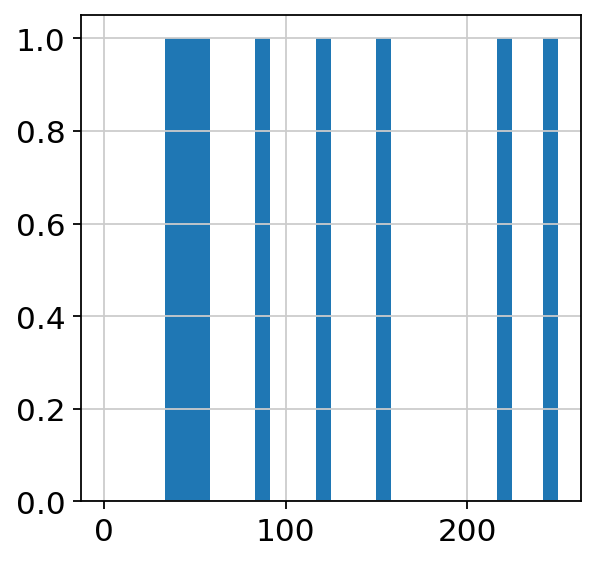

In [19]:
plt.hist(adata_pb.obs.psbulk_n_cells, 30, range=(0, 250));

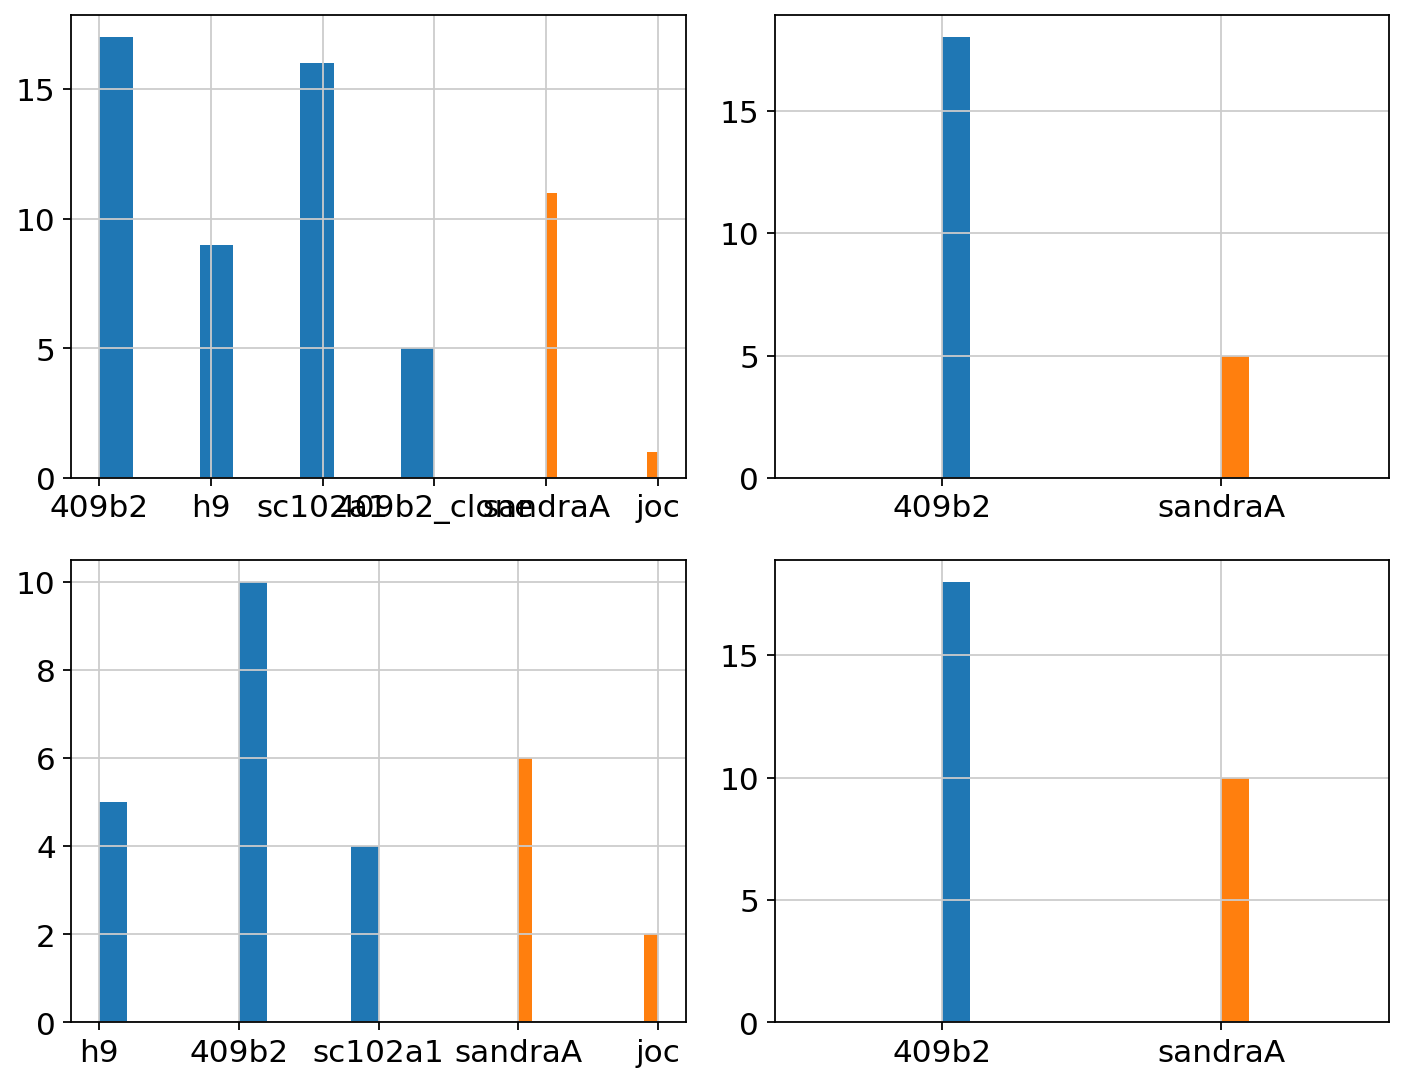

In [42]:
tp_unique = adata_pb.obs.timepoint_mapped.unique()
fig, axs = plt.subplots(int(np.ceil(len(tp_unique) / 2)) , 2, figsize=(9, 7))
for i, tp in enumerate(tp_unique):
    tmp = adata_pb.obs[
        (adata_pb.obs.timepoint_mapped == tp)
        & adata_pb.obs.isHuman ]
    axs[i // 2][i % 2].hist(tmp.line)
    tmp = adata_pb.obs[
        (adata_pb.obs.timepoint_mapped == tp)
        & np.logical_not(adata_pb.obs.isHuman) ]
    axs[i // 2][i % 2].hist(tmp.line)
plt.tight_layout()
plt.show()

In [45]:
sum(adata.obs.line == 'joc'), sum(adata.obs.line == 'sandraA')

(379, 5653)

use cluster or group?
whether samples in 

# edgeR

In [46]:
filter_low_counts = config.PROTO.GLM.FILTER
include_time = config.PROTO.GLM.INCLUDE_TIME

In [47]:
%%time
%%R -i adata_pb -i filter_low_counts -i include_time -o tt

outs <- degs(adata_pb, filter_low_counts, include_time)
myContrast <- makeContrasts(
    "isHumanTRUE.d5-isHumanFALSE.d5", levels=outs$y$design)
qlf <- glmQLFTest(outs$fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: De

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


CPU times: user 31.1 s, sys: 717 ms, total: 31.8 s
Wall time: 32 s


In [48]:
factors = [ 'd{}'.format(t) for t in config.PROTO.SUBSET.TIMEPOINTS ]

In [49]:
%%R -i factors -o qlfs

qlfs <- list()
for (factor in factors) {
    contrast <- paste0(
        "isHumanTRUE.", factor, "-isHumanFALSE.", factor)
    myContrast <- makeContrasts(contrast, levels=outs$y$design)
    qlf <- glmQLFTest(outs$fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    tt <- tt$table
    qlfs[[factor]] <- tt
}

In [50]:
# add the table to .uns for each cell type
ranks = dict()
for postfix, tt in qlfs.items():
    tt["gene_symbol"] = tt.index
    tt["time"] = postfix
    sc_toolbox.tools.de_res_to_anndata(
        selected,
        tt,
        groupby="time",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + postfix,
    )
    ranked = sc.get.rank_genes_groups_df(
        selected, group=postfix, key="edgeR_{}".format(postfix))
    ranks[postfix] = ranked.sort_values(by='scores')
    

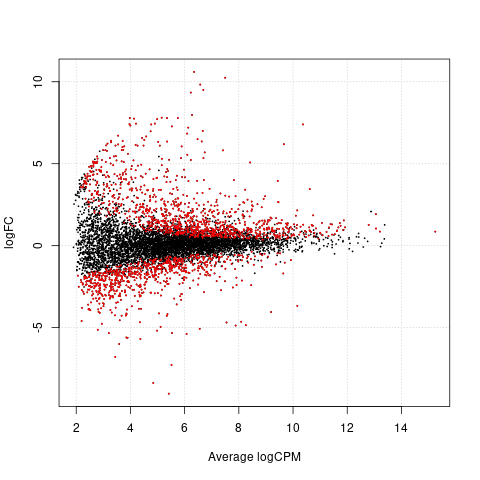

In [51]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR< .01)])

# Visualisation

In [52]:
selected.X = selected.layers["counts"].copy()
sc.pp.normalize_total(selected, target_sum=1e6)
sc.pp.log1p(selected)

# Day 5th

Plotting 1090 genes...


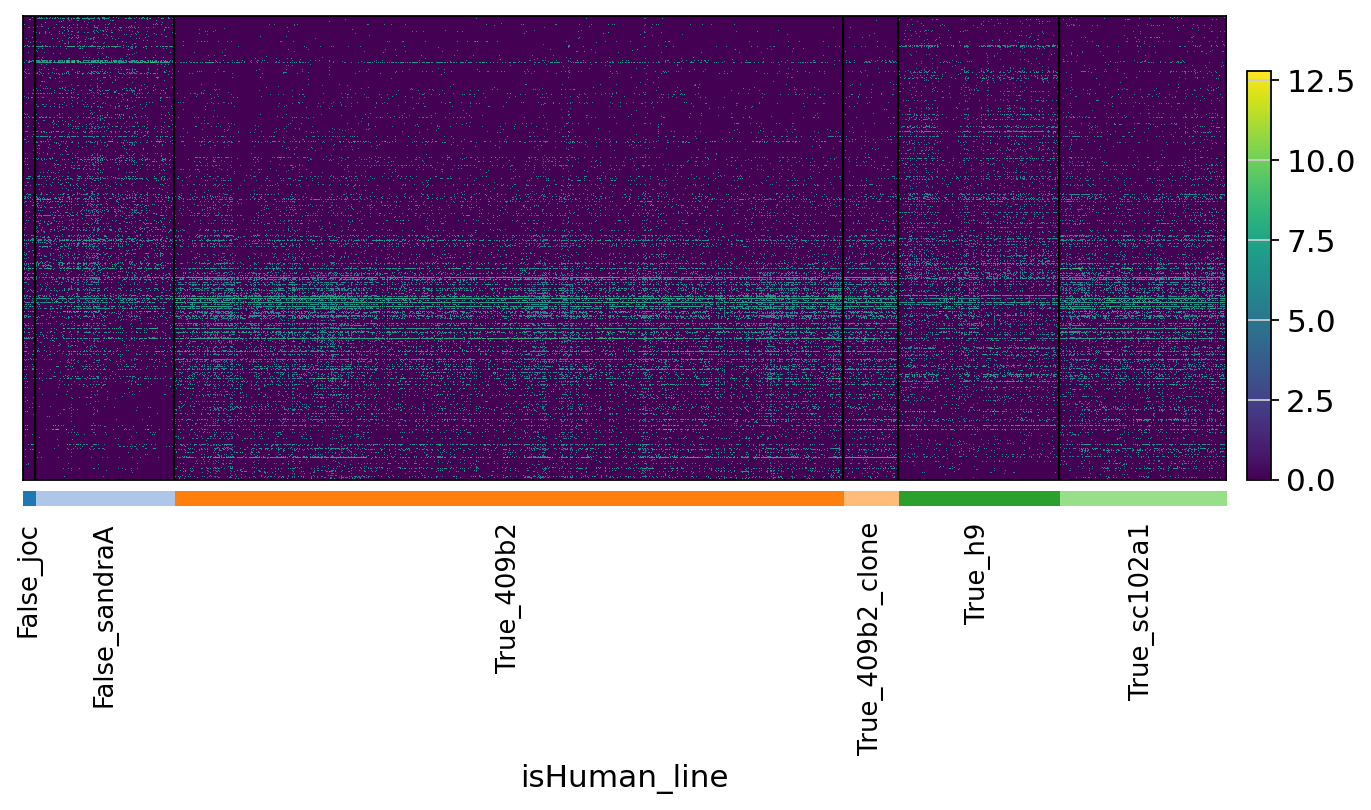

In [53]:
postfix = 'd5'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [54]:
ranks[postfix].to_csv(config.PATHS.LOGS/'w1_markers.csv')
print(' '.join(markers))

BX255923.3 AJAP1 AC074183.4 CTSF RIT2 GSTT2B C5orf63 NEMP1 PWP2 LYNX1 SLC32A1 RP11-109E12.1 WDR72 MEIOB CDX2 CRYBA1 AC005523.2 GAD2 ADAMTS6 GRIA1 YAP1 RP13-39P12.3 GRM7 COMT RORA-AS1 DNM1P35 OPRK1 MEIG1 MTRNR2L10 AC131056.3 NDNF LA16c-380H5.6 TRABD2A NPIPB15 LIMD1 TUBB8 PTH1R PAX2 XCL1 AC138969.4 PGM5P3-AS1 HAPLN4 RP11-89K21.1 FOXD4 CADPS2 NPAP1 FAM46B RASL11A ERBB4 RP11-506M13.3 UTS2 FCGBP ZNF221 ITGA6 TH TMEM132C COL4A5 CSPG4 C18orf42 NALCN BMP7 MTRNR2L12 SP140L LINC00698 SLC2A14 KIF18B LL22NC03-32F9.1 ZNF528 KLF5 SEPP1 PTPRT TUBA1C RAB37 DLGAP1-AS2 ELF3 ZNF578 TEX22 SLC6A11 ASCL1 WNT4 LINC00152 SLC18A2 LRP2 RP11-430G17.3 ENPEP HS3ST4 HSPA1B RRM2 LCAT ROBO3 SOX21 DCAF6 STXBP5-AS1 MAMDC2 GPC4 RP11-357H14.17 SLC30A3 CTD-2021H9.3 TRIM22 NPIPB6 KCNJ11 RLN2 KLC3 SRRM4 MTRNR2L1 DHDH MTRNR2L8 ADAMTS1 MYO3A ATP5EP2 SYDE1 ERCC6L RP11-480C16.1 MCPH1-AS1 FZD10 C11orf70 SLC17A8 DYDC2 KISS1 NACC2 PRRX2 SORCS1 BUB1 TRIM25 IL1RAPL1 RP11-81A22.5 NRXN3 DEPDC1 OIP5 GSAP BCAM MYO5C NOTCH2 RDM1 PEAR1 CH

# Week 2

Plotting 820 genes...


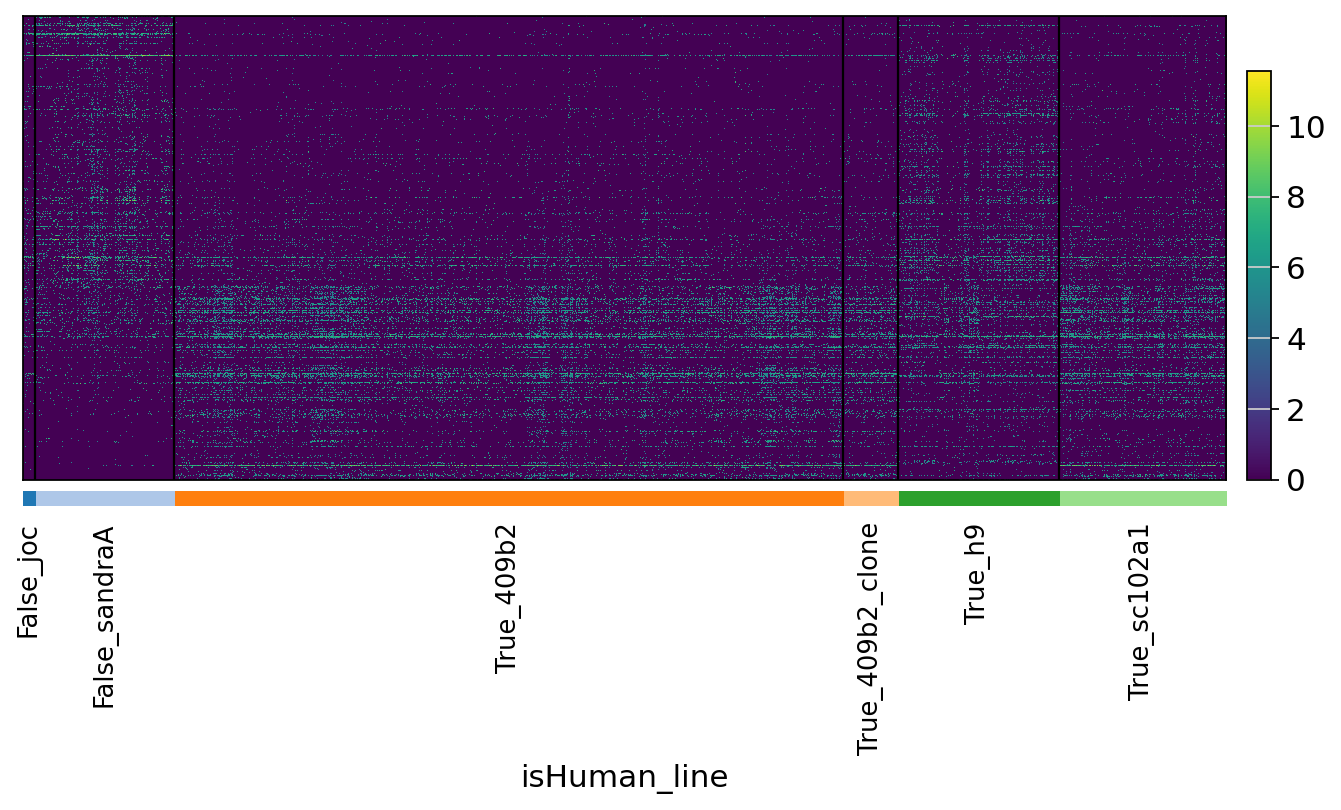

In [55]:
postfix = 'd14'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [56]:
ranks[postfix].to_csv(config.PATHS.LOGS/'w2_markers.csv')
print(' '.join(markers))

GSTT2B BX255923.3 NEMP1 AC074183.4 PGM5P3-AS1 FCGBP PRSS3 KLF5 MEIOB C5orf63 TUBB8 SYK TRABD2A NPIPB15 C11orf70 XCL1 TUBA1C CTSF UTS2 MTRNR2L10 PRIMA1 HOXA3 RP11-109E12.1 MEIG1 ATP5EP2 TEX22 SVIL-AS1 MCPH1-AS1 SLC2A14 RP11-506M13.3 MTRNR2L12 FAM46B MTRNR2L1 AC131056.3 B3GLCT CTD-2021H9.3 EMP1 IRAK1 DTL NPAP1 RP11-567C20.2 SPHKAP AC005523.2 HOXB-AS3 FOXB1 AC010884.1 CA4 CFAP77 CHKB-AS1 MKI67 FAM162B HOXB9 CCDC81 RIT2 CTB-193M12.5 ERCC6L PAX7 PBK STK26 OTX1 MCM10 UHRF1 RASL11A DHDH CADPS2 C2orf40 SULT1E1 LYNX1 ADAMTS6 NBEAL1 RSG1 DLGAP5 LA16c-380H5.6 KIF2C GSAP FST RP11-573D15.2 RORA-AS1 ANXA11 HOXA5 ECHDC3 RP1-120G22.11 RAB38 RP4-621F18.2 HLA-E CRYBA1 ASF1B TNMD MTRNR2L8 NTF4 HAPLN3 BMP3 ARPIN MAP1LC3B2 CDC45 DMC1 DYDC2 MYO1E SP5 CENPA SLC32A1 ADCY8 C20orf195 RP3-460G2.2 CDC20 KIF18B SP140L PYDC1 AC004231.2 IL13RA1 RP11-357H14.17 BRCA2 GDPD2 TNFRSF9 ADGRG6 HOXB-AS1 MIR4458HG ENPEP E2F2 KIFC1 FOXD4 CD36 C6orf141 ANKRD1 C16orf95 ZNF596 RP11-165A20.3 BMP8B LXN PLA2G7 AC113189.5 TROAP TXNRD

# 28 Days Later

Plotting 676 genes...


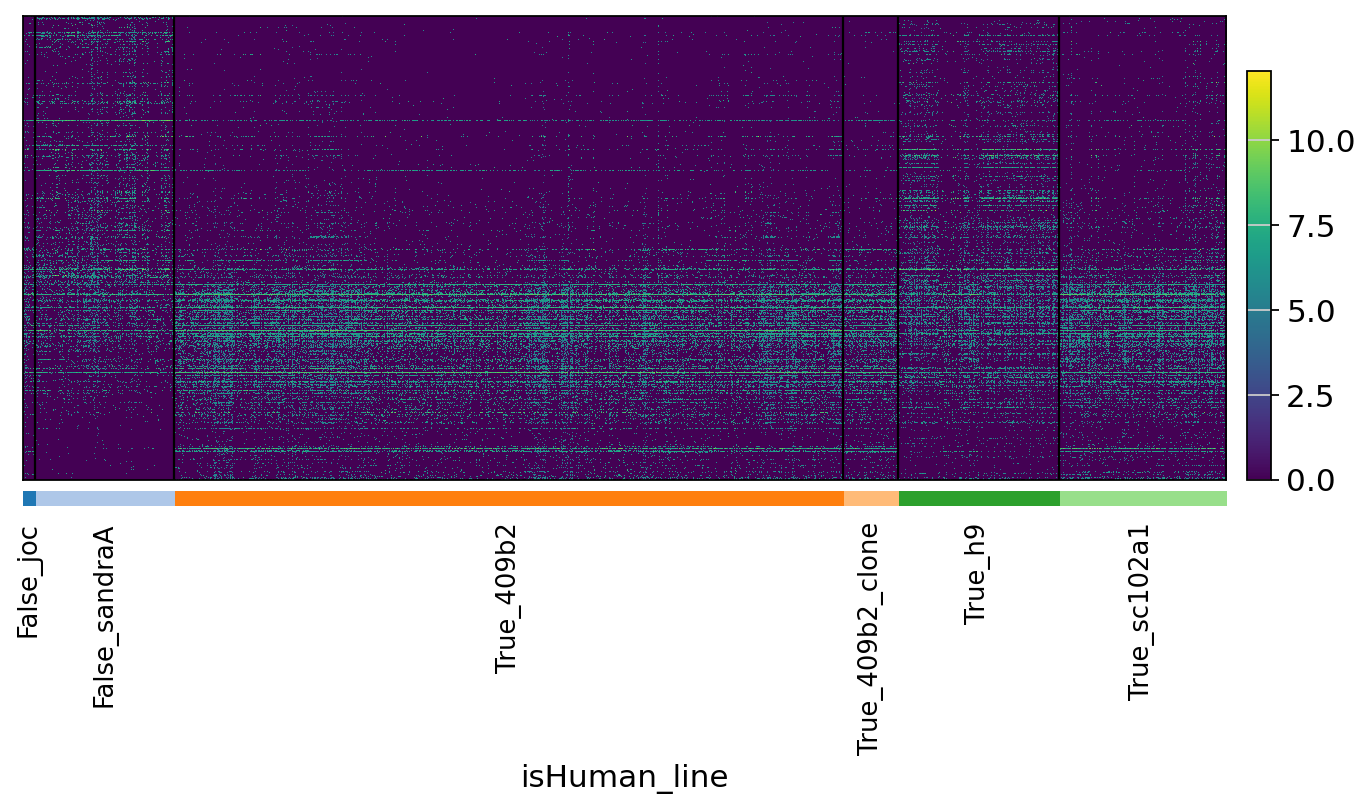

In [57]:
postfix = 'd28'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [58]:
ranks[postfix].to_csv(config.PATHS.LOGS/'w4_markers.csv')
print(' '.join(markers))

MEIOB AJAP1 BX255923.3 GSTT2B AC074183.4 CTSF TMEM132C PGM5P3-AS1 CHL1 TEX22 PWP2 MTRNR2L12 COL4A6 CYP1B1 OTX2 MMRN1 CYP26A1 MEIG1 SLC2A14 CLDN1 PALMD RGCC FCGBP RSPO1 MTRNR2L8 TRABD2A NUF2 FOXJ1 TUBA1C MTRNR2L10 HSD17B2 RP11-109E12.1 RORA-AS1 RP11-15H20.7 NPIPB15 CFI CA2 WLS RP11-255M2.3 HLA-E KLF5 COL4A5 GDPD2 GJA1 LXN NEMP1 RP13-39P12.3 LAMB2 COL9A1 TAGLN RAB38 YAP1 GPX8 MCPH1-AS1 CASP7 CDK2 ZIC2 KIF20A LRP2 C5orf63 RP11-178C3.2 ACSF2 RASL11A ZIC3 AJUBA MYBL2 CRIP1 ADAMTS16 HMGA2 CCL2 C11orf70 EFS ADGRG6 NEIL3 ZNF221 WFDC3 ECHDC3 ZIC5 ZIC1 TTK CRYBA1 EMX2 TK1 RHOJ PROM1 DMRTA2 NR2F2-AS1 MFAP4 RSPO3 EPHA2 OTX1 GRM7 FAP CHRDL1 THBS1 C22orf15 SFRP2 PRRX1 CHKB-AS1 ITGA5 ATP1A2 LHX2 PTRF E2F2 LYPD6 RNF135 ERICH5 PRSS3 ALPK2 DKKL1 AC005523.2 HIST1H1D RAD51 LDLRAP1 COL11A1 SFRP1 TGFA OLIG3 MYO1E BACE2 PLAC9 LRRC17 UBE2C TEAD3 SDC2 XCL1 ACTA2 IRAK1 PAPSS2 CELSR1 DLGAP5 NTF4 ERBB4 ENO3 TM4SF1 IQGAP3 UHRF1 ZIC4 TBL1X DAPL1 RAD51AP1 RRM2 AC002454.1 ENPP2 RP11-637A17.2 IGFBP2 COL22A1 RP11-603J2

# Week 5

Plotting 966 genes...


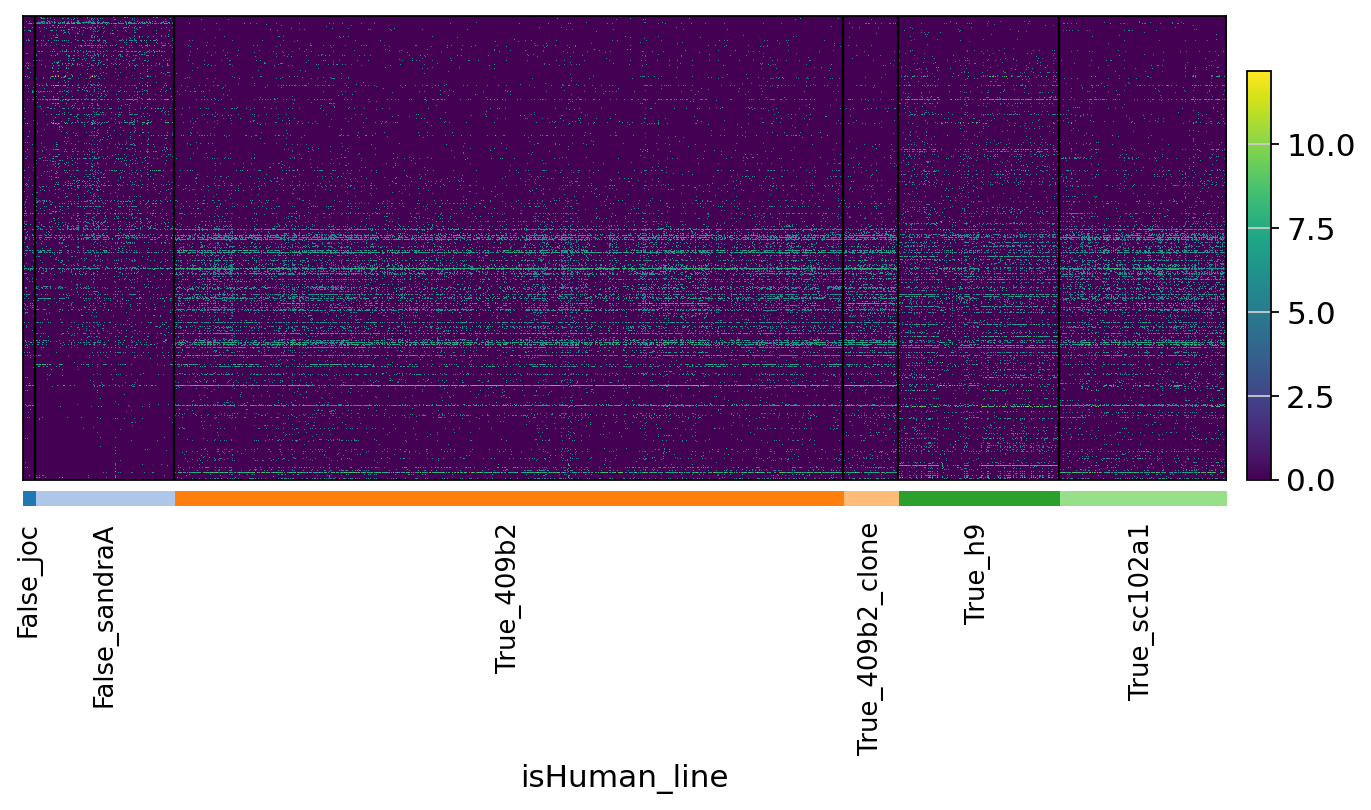

In [59]:
postfix = 'd35'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [60]:
ranked.to_csv(config.PATHS.LOGS/'w5_markers.csv')
print(' '.join(markers))

BX255923.3 AC074183.4 MEIOB PGM5P3-AS1 XCL1 MTRNR2L10 RP11-109E12.1 RP11-255M2.3 NPIPB15 FCGBP NEMP1 TRABD2A C5orf63 GSTT2B MEIG1 MTRNR2L8 MTRNR2L12 RP11-357H14.17 MTRNR2L1 BGN TUBA1C CTB-193M12.5 TEX22 AC005523.2 RP11-15H20.7 ZNF221 AC010884.1 CYP1B1 PVALB KLF5 RP13-39P12.3 SFRP4 SP140L ATP5EP2 SLC2A14 TUBB8 SLC32A1 LYNX1 CFI SULT1E1 ADGRG6 HOXC9 RP11-89K21.1 CTSF COL8A1 FAP HSD17B2 TGFA RP11-506M13.3 NBEAL1 TNFRSF10D CHKB-AS1 TRAC RFPL2 PRSS3 FOXD4 CLDN1 MCPH1-AS1 RP11-354E11.2 EMP1 CTD-2021H9.3 ADGRL2 AC131056.3 RP11-60L3.6 RP13-516M14.4 UHRF1 IGFBP7 DNM1P35 CA4 HOXA5 ZNF596 SALL3 HOXB9 IRAK1 LRRC17 DGCR9 AC138969.4 SYTL2 PLCD3 SYNPR B3GLCT AC004231.2 NHSL2 ELN NPIPB6 P3H2 ECHDC3 SDCBP2-AS1 DHDH PLA2G7 RLN2 MAP1LC3B2 EIF5AL1 RORA-AS1 DNM3OS CLDN11 ITGA1 ITGB5 RP11-166B2.1 RP11-81A22.5 ANOS1 LA16c-380H5.6 AC113189.5 IL13RA1 COL9A1 CRYBA1 FZD1 HOXB-AS3 OLFML2A THSD4 SDC2 PLEKHH2 SOSTDC1 ITGA4 RP11-178C3.2 C7 EMILIN1 CA2 RP11-16P6.1 SYK INHBA FKBP1C TGFB2 FBLN5 LXN MGP TGM2 COL12A1 GCN

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f07ecb21dc0>
